In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install git+https://github.com/huggingface/nlp
!pip install --quiet transformers==2.11.0
!pip install --quiet nlp==0.2.0
!pip install --quiet datasets

     |████████████████████████████████| 674 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 12.5 MB/s 
     |████████████████████████████████| 5.6 MB 30.8 MB/s 
     |████████████████████████████████| 1.2 MB 30.7 MB/s 
     |████████████████████████████████| 857 kB 5.2 MB/s 
     |████████████████████████████████| 312 kB 5.0 MB/s 
     |████████████████████████████████| 133 kB 56.0 MB/s 
     |████████████████████████████████| 243 kB 48.1 MB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 43.5 MB/s 
     |████████████████████████████████| 144 kB 56.9 MB/s 
     |████████████████████████████████| 271 kB 48.0 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import transformers
import nlp
from tqdm.notebook import tqdm
import numpy as np

from datasets import load_dataset, Dataset, concatenate_datasets
import matplotlib.pyplot as plt
import logging
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
logging.basicConfig(level=logging.CRITICAL)

import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import unicodedata

import json
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [ ]:
# utility methods
# save dict -> json
def to_json(save_location, file_name, dict_: dict):
  try:
    with open(f'{save_location}/{file_name}', 'w') as fp:
      json.dump(dict_, fp)
    return True 
  except Exception as e:
    return e

# download JSON based file in dictionary format
def get_json(path_to_file):
  with open(path_to_file, 'r') as openfile:
      articles = json.load(openfile)
  return articles

# extract pair ids
def get_pair_indices(data: pd.DataFrame, sep='_'):
  index_pair = data.progress_apply(
      lambda row: row['pair_id'].split(sep),
      axis=1
  )
  id_1, id_2 = list(zip(*index_pair.to_list()))
  return id_1, id_2

------
#### Preprocessing

In [ ]:
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# preprocessing methods
# replace non definite punctuations
def replace_content(text):
  replace_dict = {
      '“': '\'',
      '”': '\'',
      '‘': '\'',
      '’': '\'',
  }
  for key, value in replace_dict.items():
    text = text.replace(key, value)
  return text

# download JSON based file in dictionary format
def get_json(path_to_file):
  with open(path_to_file, 'r') as openfile:
      articles = json.load(openfile)
  return articles

# get contraction file in JSON format
CONTRACTION_MAP = get_json('../dataset/contractions.json')


# remove html tags and related content
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});') 
def clean_html(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

# replace pronounciation chars with normalized alphabets
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

# remove content withing brackets
def remove_text_within_brackets(text):
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('\(.*?\)', '', text)
  return text

# remove URLs
def remove_hyperlinks(text):
  text = re.sub('https?://\S+|www\.\S+', '', text)
  return text

# expand contraction
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
  contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                    flags=re.IGNORECASE|re.DOTALL)
  def expand_match(contraction):
      match = contraction.group(0)
      first_char = match[0]
      expanded_contraction = contraction_mapping.get(match)\
                              if contraction_mapping.get(match)\
                              else contraction_mapping.get(match.lower())                       
      expanded_contraction = first_char+expanded_contraction[1:]
      return expanded_contraction
      
  expanded_text = contractions_pattern.sub(expand_match, text)
  # expanded_ text = re.sub("'", "", expanded_text)
  return expanded_text

# remove any character except alphabets
def remove_special_characters(text, remove_digits=False):
  pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)
  return text

# lemmatization
def lemmatize_text(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

# remove stopwords 
def remove_stopwords(text, is_lower_case=False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
      filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
      filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text

def normalize_text(doc, contraction_expansion=False, remove_html=True,
                     accented_char_removal=False, text_lower_case=False, 
                     text_lemmatization=False, special_char_removal=False, 
                     stopword_removal=False, remove_digits=False, 
                     remove_brac_content=False, remove_urls=True):
    
  normalized_corpus = []
  # normalize each document in the corpus
  # remove html tags
  if remove_html:
    doc = clean_html(doc)
  # remove accented characters
  if accented_char_removal:
    doc = remove_accented_chars(doc)
  # expand contractions    
  if contraction_expansion:
    doc = expand_contractions(doc)
  # lowercase the text    
  if text_lower_case:
    doc = doc.lower()
  # remove extra newlines
  doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
  # lemmatize text
  if text_lemmatization:
    doc = lemmatize_text(doc)
  if remove_urls:
    doc = remove_hyperlinks(doc)
  # remove special characters and\or digits   
  if remove_brac_content:
    doc = remove_text_within_brackets(doc) 
  if special_char_removal:
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    doc = special_char_pattern.sub(" \\1 ", doc)
    doc = remove_special_characters(doc, remove_digits=remove_digits)  
  # remove extra whitespace
  doc = re.sub(' +', ' ', doc)
  # remove stopwords
  if stopword_removal:
    doc = remove_stopwords(doc, is_lower_case=text_lower_case)
      
  return doc
  
# convert dataframe to dictionary
def convert_df2dict(data: pd.DataFrame):
  # convert to dictionary
  # columns = ['id', 'text']
  # output = {'id_i': 'text_i'} 
  dict_ = data.to_dict()
  # get index and text
  indices = list(dict_['id'].values())
  texts = list(dict_['text'].values())
  # merge to dict
  processed_dict = dict()
  for index, text in zip(indices, texts):
    processed_dict[index] = text  
  return processed_dict

# merge pairs
def generate_pair_dict(target_dict: dict, index_a: list, index_b: list):
  proposed_dict = dict()
  # debug 
  faulty_pairs = []
  # -----
  for serial_nos, (id_1, id_2) in tqdm(enumerate(zip(index_a, index_b)), total=len(index_a)):
    # note: not attaching the scores
    try:
      proposed_dict[f'sr_{serial_nos}'] = dict(
          index_a=id_1,
          index_b=id_2,
          text_a=target_dict[id_1],
          text_b=target_dict[id_2],
      )
    except Exception as e:
      faulty_pairs.append(f"{id_1}_{id_2}")
  return proposed_dict, faulty_pairs

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

-----
#### FNC-1

In [ ]:
bodies_df = pd.read_csv("../dataset/FNC/train_bodies.csv")
stances_df = pd.read_csv("../dataset/FNC/train_stances.csv")
fnc_data = pd.merge(stances_df, bodies_df, on="Body ID", how="inner")

In [ ]:
bodies_df

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...
...,...,...
1678,2528,Intelligence agencies hunting for identity of ...
1679,2529,"While Daleks ""know no fear"" and ""must not fear..."
1680,2530,More than 200 schoolgirls were kidnapped in Ap...
1681,2531,A Guantanamo Bay prisoner released last year a...


In [ ]:
stances_df

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree
...,...,...,...
49967,Urgent: The Leader of ISIL 'Abu Bakr al-Baghda...,1681,unrelated
49968,Brian Williams slams social media for speculat...,2419,unrelated
49969,Mexico Says Missing Students Not Found In Firs...,1156,agree
49970,US Lawmaker: Ten ISIS Fighters Have Been Appre...,1012,discuss


In [ ]:
fnc_data

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\n\n...
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
...,...,...,...,...
49967,Amazon Is Opening a Brick-and-Mortar Store in ...,464,agree,"Amazon, the cyber store that sells everything,..."
49968,Elon University has not banned the term ‘fresh...,362,agree,"ELON, N.C. – A recent rumor claims that Elon U..."
49969,Fake BBC News website set up to carry Charlie ...,915,agree,A realistic-looking fake BBC News website has ...
49970,Apple was forced to nix key health features fr...,407,discuss,The health-focused smartwatch that Apple initi...


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(fnc_data['Stance'])
fnc_data['Stance'] = le.transform(fnc_data['Stance'])
# reorder and shuffle data
fnc_data = fnc_data[['Headline', 'articleBody', 'Stance', 'Body ID']]
fnc_data = fnc_data.sample(frac=1).reset_index(drop=True)

In [ ]:
# fnc_data.to_csv("/content/drive/MyDrive/SemEval-Akash_Nidhir_Rishikesh/SemEval 2022 - Multilingual Document Similarity/Semeval-Task-8/dataset/external_data/FNC_1/fnc_1_v2.csv", index=False)

In [ ]:
path_to_fnc_data = "../dataset/FNC/fnc_1.csv"
data_df = pd.read_csv(path_to_fnc_data)

  0%|          | 0/44382 [00:00<?, ?it/s]

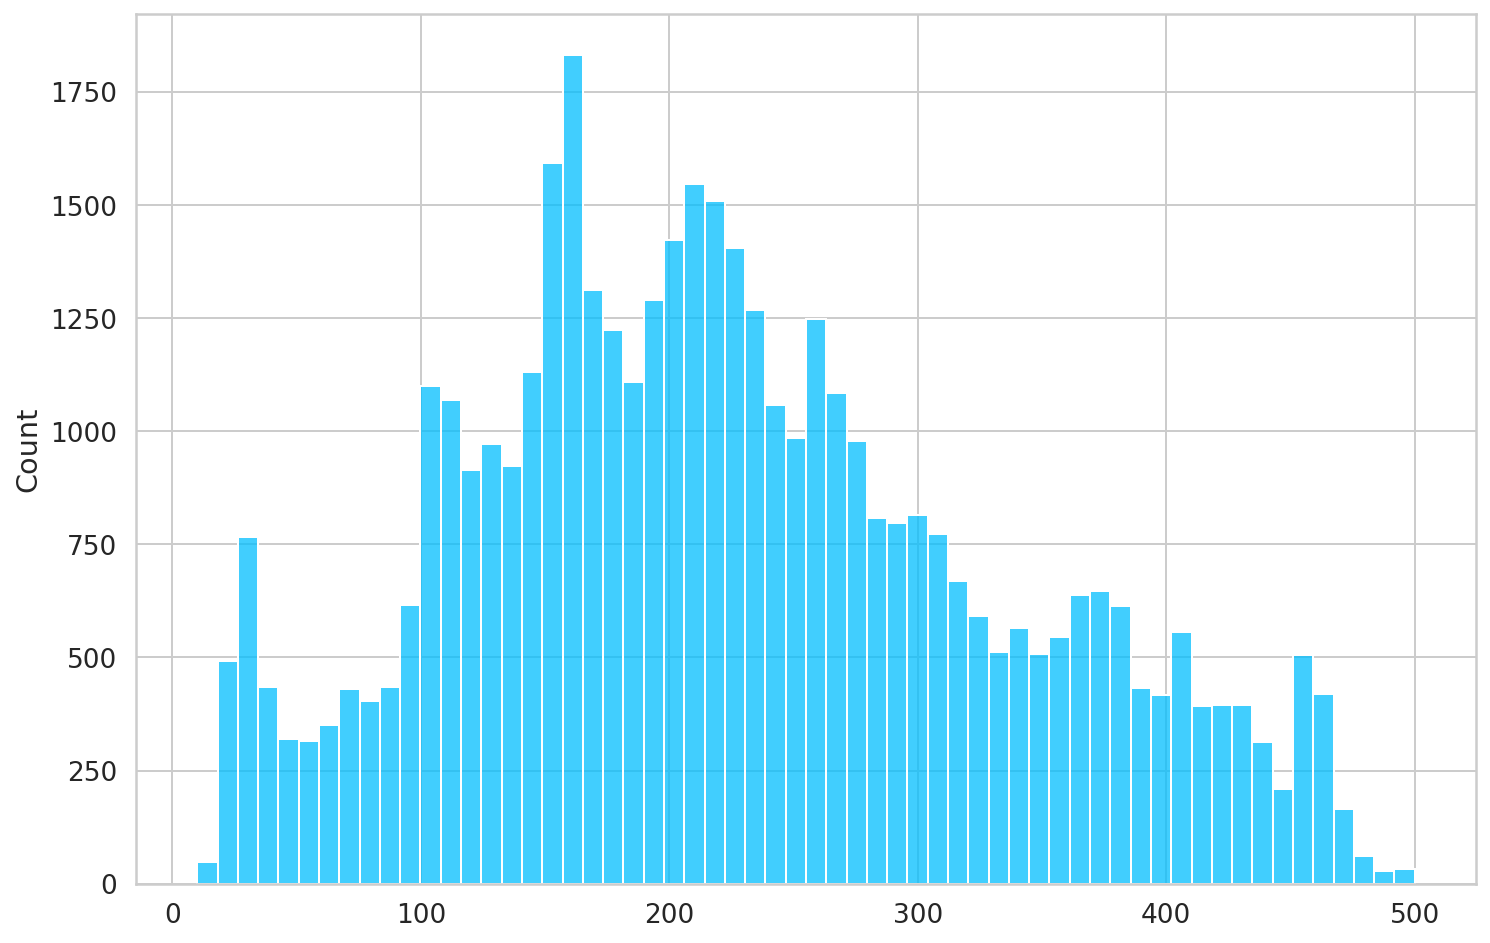

In [ ]:
# tokens = []
# indices = []
# for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
#   token = len(tokenizer.encode(
#       row['Headline'] + ' ' + tokenizer.sep_token + ' ' + row['articleBody'],
#       max_length=512
#   ))
#   tokens.append(token)
#   if token==512:
#     indices.append(index)

# sns.histplot(tokens)

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.15)
train_df, validation_df = train_test_split(train_df, test_size=0.15)
train_df.shape, validation_df.shape, test_df.shape

train_df['idx'] = np.arange(train_df.shape[0])
test_df['idx'] = np.arange(test_df.shape[0])
validation_df['idx'] = np.arange(validation_df.shape[0])

train_df.to_csv('../dataset/FNC/train.csv', index=False)
test_df.to_csv('../dataset/FNC/test.csv', index=False)
validation_df.to_csv('../dataset/FNC/validation.csv', index=False)

---
#### Hyperpartisan dataset

In [ ]:
import os
import textwrap
import xml.etree.ElementTree as ET

In [ ]:
path_to_dir = "../dataset/hyperpartisan_dataset"
labels_file = f"{path_to_dir}/ground-truth-training-bypublisher-20181122.xml"
articles_file = f"{path_to_dir}/articles-training-bypublisher-20181122.xml"

In [ ]:
tcols = ["title", "published_at", "id", "hyperpartisan", "text"]
row = []

labels = {}
with open(labels_file, "rb") as f_labels:
  tree = ET.parse(f_labels)
  root = tree.getroot()
  for label in root:
    article_id = label.attrib["id"]
    del label.attrib["labeled-by"]
    labels[article_id] = label.attrib

with open(articles_file, "rb") as f_articles:
  tree = ET.parse(f_articles)
  root = tree.getroot()
  for idx, article in enumerate(root):
      example = {}
      example["title"] = article.attrib["title"]
      example["published_at"] = article.attrib.get("published-at", "")
      example["id"] = article.attrib["id"]
      example = {**example, **labels[example["id"]]}
      example["hyperpartisan"] = example["hyperpartisan"] == "true"

      example["text"] = ""
      for child in article:
          example["text"] += ET.tostring(child).decode() + "\n"
      example["text"] = example["text"].strip()
      row.append(example)
      article.clear()

# create dataframe
data_df = pd.DataFrame(row, columns=cols)
# save file to csv
data_df.to_csv(f'{path_to_dir}/Data/main.csv', index=False)

-----
##### Post processing

In [ ]:
path_to_dir = "../dataset/hyperpartisan_dataset"
# bypublisher articles data
articles = pd.read_csv(f'{path_to_dir}/Data/main.csv')

# ground-truth labels
labels = get_json(f'{path_to_dir}/Data/labels.json')
# convert lables dictionary to pandas dataframe
labels_df = pd.DataFrame([item for item in labels.values()], columns=['bias', 'hyperpartisan', 'id', 'url'])
labels_df['id'] = labels_df['id'].astype(np.int64) # change str -> int64

In [ ]:
hyperpartisan_df = pd.merge(articles, labels_df, on='id', how='outer')
# drop hyperpartisan_y column
hyperpartisan_df.drop(['hyperpartisan_y'], axis=1, inplace=True)
# convert True/False -> 0/1
hyperpartisan_df['hyperpartisan_x'] = hyperpartisan_df['hyperpartisan_x'].astype('int')

# convert bias values into unique classes.
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(hyperpartisan_df['bias'])
hyperpartisan_df['bias']=label_encoder.transform(hyperpartisan_df['bias'])

# drop non-related columns
hyperpartisan_df.drop(['published_at', 'url'], axis=1, inplace=True)
hyperpartisan_df.rename(columns={'hyperpartisan_x': 'hyperpartisan', 'id': 'idx'}, inplace=True, errors='raise')
hyperpartisan_df = hyperpartisan_df[['title', 'text', 'hyperpartisan', 'bias', 'idx']]

# drop null values
hyperpartisan_df.dropna(inplace=True)
# sample 60000 values
sample_data = hyperpartisan_df.sample(60000)

In [ ]:
sample_data['preproc_text'] = sample_data.progress_apply(
    lambda row: normalize_text(row['text']),
    axis = 1
)

sample_data['preproc_title'] = sample_data.progress_apply(
    lambda row: normalize_text(row['title']),
    axis = 1
)
sample_data.to_csv(f'{path_to_dir}/Data/sample.csv', index=False)

  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/60000 [00:00<?, ?it/s]

In [ ]:
sample_data

,title,text,hyperpartisan,bias,idx,preproc_text,preproc_title
569321,City should proactively weigh CHCC buyer's bul...,<p>.......... .......... .......... .............,0,0,1418782,.......... .......... .......... .......... .....,City should proactively weigh CHCC buyer's bul...
452795,Football trumps politics as 2018 Georgia Legis...,<p>ATLANTA (AP) &#8212; Politics took a backse...,0,0,1129692,ATLANTA (AP) Politics took a backseat to colle...,Football trumps politics as 2018 Georgia Legis...
581078,Scientists: Current International Warming Targ...,<p>Devastation in the wake of Typhoon Haiyan. ...,1,1,1448163,Devastation in the wake of Typhoon Haiyan. lt;...,Scientists: Current International Warming Targ...
296469,Amy Schumer's dad stands with 'help' after yea...,"<p>Nov. 17 (UPI) &#8212; <a href=""https://www....",0,4,742130,Nov. 17 (UPI) Amy Schumers dad stood up with h...,Amy Schumer's dad stands with 'help' after yea...
153286,Google Glass is dead — for now,<p>While smartglasses will still be sold as a ...,0,2,380535,While smartglasses will still be sold as a com...,Google Glass is dead — for now
...,...,...,...,...,...,...,...
276324,The Best Dividend Stock in the Memory Chip Ind...,<p /> \n\n<p>Though the memory chip market mig...,1,3,692203,Though the memory chip market might seem like...,The Best Dividend Stock in the Memory Chip Ind...
438034,Turkey&apos;s Erdogan says U.S. courts cannot ...,<p>ANKARA (Reuters) &#8211; Courts in the Unit...,0,4,1093441,ANKARA (Reuters) Courts in the United States c...,Turkeys Erdogan says U.S. courts cannot put Tu...
458443,Prospective Renters Getting the Third Degree,<p>.......... .......... .......... .............,0,0,1143675,.......... .......... .......... .......... .....,Prospective Renters Getting the Third Degree
31774,"Well done, sir! Cop pulls over to toss footbal...",<p>A police officer in Texas pulled over for a...,1,3,79052,A police officer in Texas pulled over for a fe...,"Well done, sir! Cop pulls over to toss footbal..."


-----
##### Analysis

In [ ]:
# sample_data = pd.read_csv(f"{path_to_dir}/Data/sample.csv")

In [ ]:
# tokenizer = transformers.AutoTokenizer.from_pretrained('roberta-base')

In [ ]:
# tokens = []
# indices = []
# for index, row in tqdm(sample_data.iterrows(), total=sample_data.shape[0]):
#   token = len(tokenizer.encode(
#       row['title'] + ' ' + tokenizer.sep_token + ' ' + row['text'],
#       max=1024
#   ))
#   tokens.append(token)
#   if token==512:
#     indices.append(index)

# sns.histplot(tokens)

#### Description 


In [ ]:
# load original semeval data version - 2
path_to_file = "../dataset/json_text_extract_v2_desc.csv"
json_df = pd.read_csv(path_to_file)
# lang count
json_df.lang.value_counts()

# extract english data
en_data = json_df[json_df['lang'] == 'en']
# drop unnecessary columns
en_data.drop(['lang', 'title', 'text', 'link'], axis=1, inplace=True)
en_data.dropna(inplace=True)
# rename columns
en_data.rename(columns={'extra_text': 'text'}, inplace=True, errors="raise")

# merge dataframes
path_to_dir = "../dataset/translation_data/desc"
paths = {
    'de': f'{path_to_dir}/trans_desc_de.csv',
    'es': f'{path_to_dir}/trans_desc_es.csv',
    'tr': f'{path_to_dir}/trans_desc_tr.csv',
    'pl': f'{path_to_dir}/trans_desc_pl.csv',
}

de_data = pd.read_csv(paths['de'])
es_data = pd.read_csv(paths['es'])
tr_data = pd.read_csv(paths['tr'])
pl_data = pd.read_csv(paths['pl'])

# concatenate data
result = pd.concat([en_data, de_data, es_data, tr_data, pl_data], axis=0)
result['id'] = result['id'].astype(str)
# reset index; otherwise it won't generate unique keys upto max_length
result.reset_index(drop=True, inplace=True)
# get dictionary
processed_dict = convert_df2dict(result)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# read main dataframe
main_df = pd.read_csv("../dataset/final_data.csv")
main_df.dropna(inplace=True)
# get pair_ids
# main_df['pair_id'] = main_df['pair_id'].astype(str)
index_a, index_b = get_pair_indices(main_df)
# pair_id 
paired_dict, faulty_pairs = generate_pair_dict(processed_dict, index_a, index_b)
# generate description dataframe (merged)
desc_df = pd.DataFrame(paired_dict.values(), columns=['index_a', 'index_b', 'text_a', 'text_b'])

  0%|          | 0/4051 [00:00<?, ?it/s]

  0%|          | 0/4051 [00:00<?, ?it/s]

In [ ]:
# create pair_id column
desc_df['pair_id'] = desc_df.progress_apply(
    lambda row: f"{row['index_a']}_{row['index_b']}",
    axis=1
)
# drop index_a, index_b and rename text_a, text_b -> desc_a, desc_b
desc_df.drop(['index_a', 'index_b'], axis=1, inplace=True)
desc_df.rename(columns={
    'text_a': 'desc_a',
    'text_b': 'desc_b'
}, inplace=True)
# merged data
unite_df = pd.merge(main_df, desc_df, on='pair_id', how='outer')
# drop duplicate row ~64
unite_df = unite_df[~unite_df.duplicated()]
# unite_df.fillna(' ', inplace=True)
unite_df.to_csv(f"{path_to_dir}/unite_data.csv", index=False)

  0%|          | 0/3735 [00:00<?, ?it/s]

In [ ]:
# create a copy
final_df = unite_df.copy(deep=True)
final_df.fillna('None', inplace=True)
# append text with description
final_df['text_a'] = final_df.progress_apply(
    lambda row:  row["desc_a"]+"|"+row["text_a"] if row['desc_a'] != 'None' else row['text_a'],
    axis=1
)
final_df['text_b'] = final_df.progress_apply(
    lambda row:  row["desc_b"]+"|"+row["text_b"] if row['desc_b'] != 'None' else row['text_b'],
    axis=1
)
# drop description columns
final_df.drop(['desc_a', 'desc_b'], axis=1, inplace=True)
# save data
final_df.to_csv("../dataset/final_desc_data.csv", index=False)

  0%|          | 0/4051 [00:00<?, ?it/s]

  0%|          | 0/4051 [00:00<?, ?it/s]